In [1]:
# 📚 Librerías Necesarias
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# ✅ Forzar el uso de CPU (si es necesario)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# ✅ Parámetros Globales
IMG_SIZE = (128, 128)  # Tamaño de las imágenes
BATCH_SIZE = 16        # Tamaño del batch
EPOCHS = 30            # Número de épocas
AUTOTUNE = tf.data.AUTOTUNE

# ✅ Rutas de Datos
ruta_train_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'


In [2]:
# ✅ Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

# ✅ Preprocesamiento de Imágenes
def cargar_datos(df, ruta_img, es_entrenamiento=True):
    ids = df['id'].values
    labels = df['clip_count'].values if 'clip_count' in df.columns else None
    
    def preprocesar_imagen(id, label=None):
        img_path = tf.strings.join([ruta_img, "/clips-", tf.strings.as_string(id), ".png"])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)  # MobileNet usa 3 canales
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return (img, tf.cast(label, tf.float32)) if label is not None else img
    
    if es_entrenamiento:
        dataset = tf.data.Dataset.from_tensor_slices((ids, labels))
        dataset = dataset.map(lambda id, label: preprocesar_imagen(id, label), num_parallel_calls=AUTOTUNE)
        dataset = dataset.cache().shuffle(1000)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(ids)
        dataset = dataset.map(lambda id: preprocesar_imagen(id), num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# ✅ Crear Datasets
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
dataset_train = cargar_datos(df_train, ruta_train_img, es_entrenamiento=True)
dataset_val = cargar_datos(df_val, ruta_train_img, es_entrenamiento=True)
dataset_test = cargar_datos(df_test, ruta_test_img, es_entrenamiento=False)


In [3]:
# ✅ Crear Modelo usando MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# ✅ Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# ✅ Añadir Capas Personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce el tamaño de los mapas de características
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Evita el overfitting
output = Dense(1, activation='linear')(x)  # Salida para regresión

# ✅ Compilar el Modelo
modelo_transfer = Model(inputs=base_model.input, outputs=output)
modelo_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# ✅ Resumen del Modelo
modelo_transfer.summary()




9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

Epoch 1/30

750/750 [==============================] - 88s 110ms/step - loss: 57.0939 - rmse: 7.5561 - val_loss: 16.4483 - val_rmse: 4.0556 - lr: 0.0010
Epoch 2/30
750/750 [==============================] - 54s 72ms/step - loss: 34.4491 - rmse: 5.8693 - val_loss: 17.9174 - val_rmse: 4.2329 - lr: 0.0010
Epoch 3/30
750/750 [==============================] - 60s 80ms/step - loss: 33.3186 - rmse: 5.7722 - val_loss: 20.0055 - val_rmse: 4.4727 - lr: 0.0010
Epoch 4/30
750/750 [==============================] - 58s 77ms/step - loss: 32.3007 - rmse: 5.6834 - val_loss: 14.5760 - val_rmse: 3.8178 - lr: 0.0010
Epoch 5/30
750/750 [==============================] - 58s 78ms/step - loss: 31.0425 - rmse: 5.5716 - val_loss: 15.8558 - val_rmse: 3.9819 - lr: 0.0010
Epoch 6/30
750/750 [==============================] - 60s 80ms/step - loss: 31.0118 - rmse: 5.5688 - val_loss: 15.2506 - val_rmse: 3.9052 - lr: 0.0010
Epoch 7/30
750/750 [==============================] - 57s 76ms/step - loss: 30.9353 - rmse: 

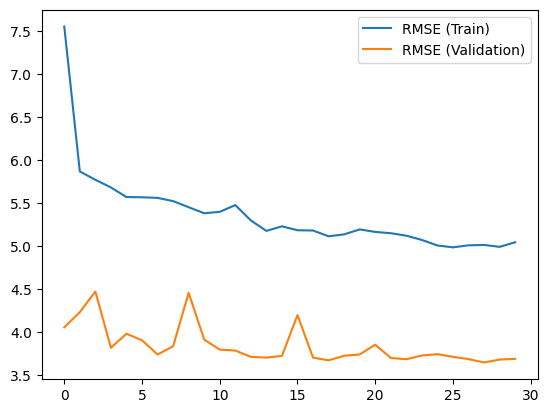

In [4]:
# ✅ Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# ✅ Entrenar Modelo
historial_transfer = modelo_transfer.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# ✅ Graficar Métricas
plt.plot(historial_transfer.history['rmse'], label='RMSE (Train)')
plt.plot(historial_transfer.history['val_rmse'], label='RMSE (Validation)')
plt.legend()
plt.show()


In [5]:
# ✅ Evaluar Modelo
train_loss, train_rmse = modelo_transfer.evaluate(dataset_train)
val_loss, val_rmse = modelo_transfer.evaluate(dataset_val)
print(f"🔹 RMSE (Train): {train_rmse:.2f}")
print(f"🔹 RMSE (Validation): {val_rmse:.2f}")

# ✅ Generar Predicciones
predicciones = modelo_transfer.predict(dataset_test).flatten()
df_test['clip_count'] = np.round(predicciones).astype(int)

# ✅ Guardar Resultados
df_test[['id', 'clip_count']].to_csv('submission_transfer_learning.csv', index=False)
print("✅ Archivo 'submission_transfer_learning.csv' generado correctamente.")

# ✅ Guardar el Modelo
modelo_transfer.save('modelo_transfer_learning.h5')
print("✅ Modelo guardado como 'modelo_transfer_learning.h5'")


188/188 [==============================] - 10s 52ms/step - loss: 13.6098 - rmse: 3.6891
🔹 RMSE (Train): 3.31
🔹 RMSE (Validation): 3.69
313/313 [==============================] - 19s 57ms/step
✅ Archivo 'submission_transfer_learning.csv' generado correctamente.
✅ Modelo guardado como 'modelo_transfer_learning.h5'


c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
